# Unsupervised Clustering with a Weighted KMeans Autoencoder

In [3]:
# needed modules 
import tensorflow as tf
import keras.backend as K
from keras.layers import Layer, InputSpec, Dense
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.cluster import KMeans 
from preprocessing import *
from autoencoder import *
from sklearn.metrics import *
import matplotlib.pyplot as plt
import sys
import os
import random
import warnings
warnings.filterwarnings("ignore")

1. Preprocess data: 

- set seed universally 
- use 'preprocess.py' to get formatted essays and corresponding labels 
- tokenize essays 
- split essays and labels into training and testing data

In [4]:
# set seed 
set_seed()

# get essays and labels
sentences, labels = preprocess_complete_ver2("../../data/pdf_texts.tsv", "text")
texts = sentences
labels = labels

# tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# text to sequences
sequences = tokenizer.texts_to_sequences(texts)

# pad sequences
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen = max_sequence_length, padding = 'post')

# split train and test data 
total_sentences = len(padded_sequences)
train_ratio = int(total_sentences * 0.8)

train_data = padded_sequences[0:train_ratio]
test_data = padded_sequences[train_ratio:total_sentences]
train_labels = np.array(labels[0:train_ratio])
test_labels = np.array(labels[train_ratio:total_sentences])

Random seed set as 42


2. Run KMeans clustering for a baseline accuracy report 

Produce accuracy metrics and confusion matrix for testing data with regular KMeans clustering. We can use this to see if our autoencoder has improved this clustering algorithm. 

Weighted KMeans clustering accuracy:  0.12195121951219512


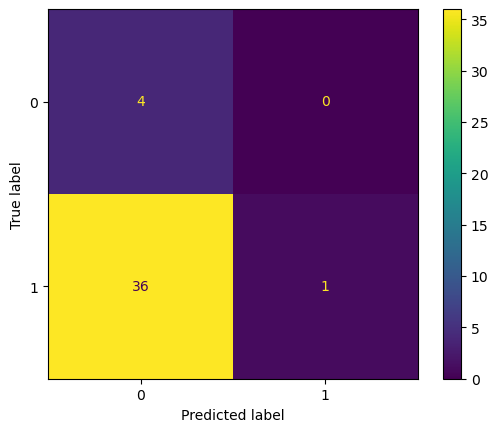

In [5]:
# get labels as weighted lists depending on label frequency
weight_list_test = get_weights(test_labels)
weight_list_train = get_weights(train_labels)

# run weighted kmeans clustering
kmeans_accuracy, kmeans_confusion_matrix = kmeans_clustering(test_data, test_labels, 2, weight_list_test)
print("Weighted KMeans clustering accuracy: ", kmeans_accuracy)

# generate confusion matrix 
kmeans_confusion_matrix.plot()

3. Run fully-connected autoencoder to pretrain before clustering

In [6]:
encoder_layer = train_noclustering(train_data, max_sequence_length)

Epoch 1/300
1/1 [==============================] - 0s 270ms/step - loss: 1075816.7500
Epoch 2/300
1/1 [==============================] - 0s 11ms/step - loss: 1075805.3750
Epoch 3/300
1/1 [==============================] - 0s 12ms/step - loss: 1075797.2500
Epoch 4/300
1/1 [==============================] - 0s 12ms/step - loss: 1075790.0000
Epoch 5/300
1/1 [==============================] - 0s 12ms/step - loss: 1075782.7500
Epoch 6/300
1/1 [==============================] - 0s 13ms/step - loss: 1075776.1250
Epoch 7/300
1/1 [==============================] - 0s 12ms/step - loss: 1075770.0000
Epoch 8/300
1/1 [==============================] - 0s 12ms/step - loss: 1075763.8750
Epoch 9/300
1/1 [==============================] - 0s 12ms/step - loss: 1075758.7500
Epoch 10/300
1/1 [==============================] - 0s 12ms/step - loss: 1075753.5000
Epoch 11/300
1/1 [==============================] - 0s 12ms/step - loss: 1075748.1250
Epoch 12/300
1/1 [==============================] - 0s 12ms/st

4. Train clustering autoencoder using the weights from the pretrained model above 

In [7]:
clustering_model, loss = train_clustering(encoder_layer, train_data, train_labels, weight_list_train)

6/6 [==============================] - 0s 1ms/step
Iter 0: acc = 0.70807  ; loss= 0
Iter 140: acc = 0.65839  ; loss= 0.0
Iter 280: acc = 0.62112  ; loss= 0.0
Iter 420: acc = 0.60248  ; loss= 0.00069
Iter 560: acc = 0.59006  ; loss= 0.00136
Iter 700: acc = 0.59006  ; loss= 0.00157
Iter 840: acc = 0.59006  ; loss= 0.00168
Iter 980: acc = 0.59006  ; loss= 0.0017
Iter 1120: acc = 0.59006  ; loss= 0.00172
Iter 1260: acc = 0.59006  ; loss= 0.00176
Iter 1400: acc = 0.59006  ; loss= 0.00168
Iter 1540: acc = 0.59006  ; loss= 0.00166
Iter 1680: acc = 0.59006  ; loss= 0.00167
Iter 1820: acc = 0.59006  ; loss= 0.0017
Iter 1960: acc = 0.59006  ; loss= 0.00165
Iter 2100: acc = 0.59006  ; loss= 0.00162
Iter 2240: acc = 0.59006  ; loss= 0.0016
Iter 2380: acc = 0.59006  ; loss= 0.0016
Iter 2520: acc = 0.59006  ; loss= 0.0016
Iter 2660: acc = 0.59006  ; loss= 0.00159
Iter 2800: acc = 0.59006  ; loss= 0.00159
Iter 2940: acc = 0.59006  ; loss= 0.00159
Iter 3080: acc = 0.59006  ; loss= 0.00159
Iter 3220: a

5. Test clustering autoencoder 

Test accuracy = 0.65854  ; loss =  0.00155


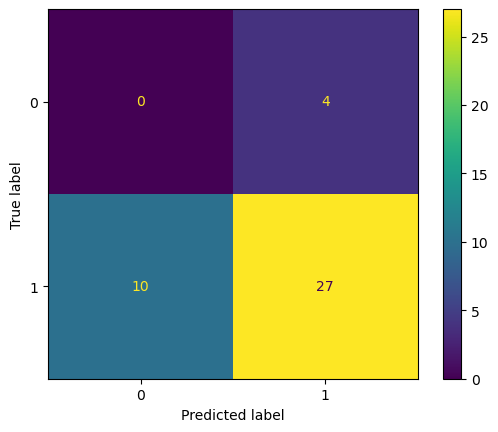

In [8]:
final = test_clustering(clustering_model, loss, test_data, test_labels)
final.plot()